Import utils

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import math

Helper functions

In [91]:
def cleanup(df : pd.DataFrame) -> pd.DataFrame:
    columns = list(df)
    #clean up all the columns
    for i in columns:
        if df[i].isnull().sum() > 0:
            x = df[i].mean()
            df[i].fillna(x, inplace = True)
    #drop dups
    df.drop_duplicates(inplace = True)
    return df


Function to approximate star mass

In [92]:
def findStarMass(luminosity,  a=3.5):
    massofsun = 1.988 * (10 **30)     # Kgs
    print(np.log10(luminosity ))
    return 10 ** (np.log10(luminosity ) / a - math.log10(massofsun))

Function to filter main sequence stars

In [93]:
def filterMainSequence(df:pd.DataFrame):
    return df.loc[df["Spectral Class"] == "M" ].copy()

Read and clean up the csv file

In [94]:
df:pd.DataFrame = pd.read_csv("starchart.csv") 
df = cleanup(df)

## A relationship between mass and radius

In order to find a relationship between the mass of a star and it's radius, I had to find the mass of these stars by taking advantage of a relationship between luminosity and mass (relative to the sun) 
https://en.wikipedia.org/wiki/Mass%E2%80%93luminosity_relation#Distinguishing_between_small_and_large_stellar_masses

### Caveats
This is imperfect. The formula is an approximation and my implementation is an approximation of this approximation. 
The formula is meant for finding luminosity based on mass, not necessarily the other way around

In [95]:
mainseq = filterMainSequence(df)
mainseq["mass"] = findStarMass(mainseq["Luminosity(L/Lo)"])

radii = mainseq[["Radius(R/Ro)"]].copy()
masses = mainseq["mass"].copy()

model = LinearRegression()

model.fit( radii, masses)

# Predict the dependent variable using the model
mass_prediction = model.predict(radii)

0     -2.619789
1     -3.301030
2     -3.522879
3     -3.698970
4     -3.860121
         ...   
195   -2.568636
196   -2.879426
197   -2.903090
198   -2.187087
199   -2.568636
Name: Luminosity(L/Lo), Length: 111, dtype: float64


Displaying the data

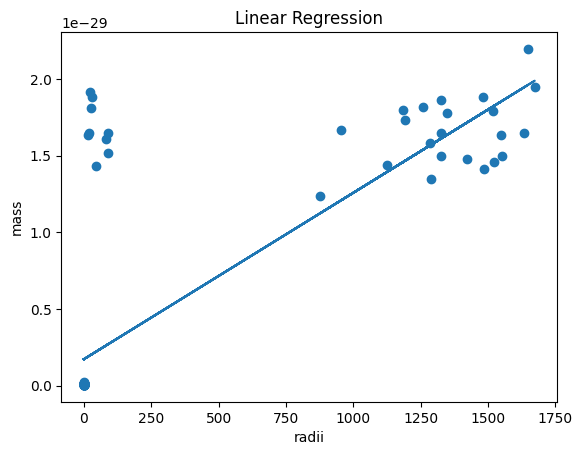

In [96]:
plt.scatter( radii, masses)
plt.plot(radii, mass_prediction)
plt.xlabel("radii")
plt.ylabel("mass")
plt.title("Linear Regression")
plt.savefig("mass_vs_radius_of_stars.png")
plt.show()

## Harvesting energy
Say we had all these stars to our disposal, which stars would be best to harvest energy from?

In other words, which star has the highest energy density, or energy / surface area

I'm using Luminosity as a proxy for energy, as they are directly proportional. 

In [97]:
def getSurfaceArea(radius):
    return np.square(radius) * np.pi * 4 

In [98]:
df["surface area"] = getSurfaceArea(df["Radius(R/Ro)"])
df["energy/area"] = df["Luminosity(L/Lo)"] / df["surface area"]

sorted = df.sort_values(by="energy/area", ascending=False)

In [99]:
print(sorted)

     Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
150            29560      188000.00000         6.020                   -4.01   
214            34190      198200.00000         6.390                   -4.57   
215            32460      173800.00000         6.237                   -4.36   
159            37800      202900.00000         6.860                   -4.56   
101            40000      813000.00000        14.000                   -6.23   
..               ...               ...           ...                     ...   
135             3243           0.00230         0.730                   14.75   
137             3598           0.00110         0.560                   14.26   
134             3542           0.00090         0.620                   14.23   
131             3607           0.00023         0.380                   10.34   
130             3095           0.00019         0.492                   10.87   

     Star type  Star color Spectral Cla

## Is there a relation between star color and energy density?

In [100]:
def findMeanDensity(star_colors, df):
    arr = []
    
    for i in star_colors:
        filteredDF = df[df["Star color"] == i]
        mean = filteredDF["energy/area"].mean()
        arr.append(mean)
        
        
    
    return arr

def shortenName(strList):
    res = []
    for i in strList:
        
        stringres = ""
        for j in i.split():
            stringres += i[0]
        res.append(stringres)

        
    return res

In [101]:
#separating values
star_color = df["Star color"].sort_values()
star_color = star_color.drop_duplicates()

density = findMeanDensity(star_color, df)
star_color = shortenName(star_color)
print(star_color)

['B', 'B', 'BB', 'BB', 'BB', 'B', 'B', 'O', 'O', 'PPP', 'R', 'W', 'W', 'W', 'Y', 'YY', 'w', 'y', 'y']


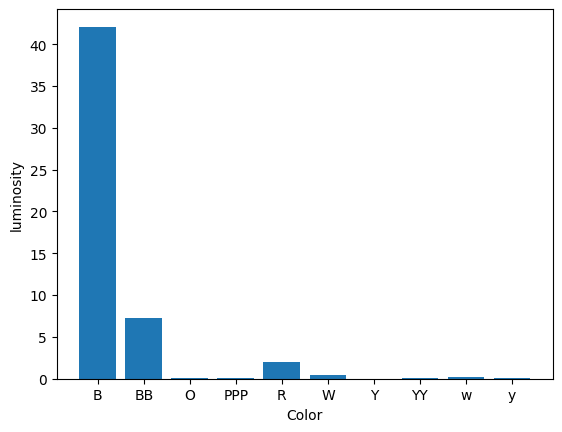

In [102]:
plt.bar(star_color, density)

plt.xlabel('Color')
plt.ylabel('luminosity')

plt.savefig("star_color_vs_energy_density.png")
plt.show()